## PPO: Proximal Policy Optimization Algorithms

[Paper: Proximal Policy Optimization](https://arxiv.org/pdf/1707.06347)

[Youtube: Natural Policy Gradients, TRPO, PPO](https://www.youtube.com/watch?v=xvRrgxcpaHY)

https://www.youtube.com/watch?v=k2pD3k1485A


### 1. Introduction
PPO：
- surrogate object function
- 一个样本经历多个epoch minibatch updates，而常规的Policy Gradient算法perform one gradient update per data sample
- 具备TRPO的优点但是更简单、better sample complexity

Q-learning:
- fails on many simple problems and is poorly understood

Vanilla PG:
- have poor data effiency and robustness

TRPO:
- complicated and is not compitable with architectures that include noise or parameter sharing


### 2.1 Policy Gradient Methods
目标奖励函数：
$$L^{PG}(\theta) = \hat{\mathbb{E}}[log\pi_{\theta}(a_t|s_t)\hat{A}_t]$$

其中$\hat{A}_t$ is an estimator of the advantage function at timestep t.
$$\hat{A}_t = q(a_t, s_t) - b(s_t)$$

使用同样的轨迹进行多次策略优化很有吸引力，但是一直未得到理论证明，并且可能会导致破坏性的策略更新：
> While it is appealing to perform multiple steps of optimization on this loss $L^{PG}$ using the same trajectory, doing so is not well-justified, and empirically it often leads to destructively large policy updates

## 2.2 TRPO
目标奖励函数：
$$\underset{\theta}{maxmize}\quad\hat{\mathbb{E}}[\cfrac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t]$$
$$s.t.\quad \hat{\mathbb{E}}_t[KL[\pi_{\theta_{old}}(*|s_t), \pi_{\theta_{old}}(*|s_t)]]\le \delta$$
因此TRPO本质上求解的是以下最优化问题：
$$\underset{\theta}{maxmize} \mathbb{\hat{E}}[\cfrac{\pi_{\theta}(a_t|s_t)}{\pi_{old}(a_t|s_t)}\hat{A}_t - \beta KL[\pi_{old}(a_t|s_t), \pi_{\theta}(a_t|s_t)]]$$

TRPO使用硬约束而非将约束带入优化目标作为惩罚项，是因为难以找到单一固定的惩罚系数$\beta$

## 3. PPO 1 : Clipped Surrogate Objective
重要性采样系数 : $r_t(\theta) = \cfrac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$, so $r_{old}({\theta})=1$。
#### TRPO最大化代理目标函数：(CPI: conservative policy iteration)
$$L^{CPI}(\theta) = \hat{\mathbb{E}}[\cfrac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t] = \hat{\mathbb{E}}[r_t(\theta)\hat{A}_t]$$
直接优化上述目标会导致很大幅度的策略更新，因此对于策略更新的幅度（$r_t(\theta)$偏离1的程度）进行惩罚。

#### PPO最大化下面代理目标函数：
$$L^{CLIP}(\theta) = \hat{\mathbb{E}}[min(r_t(\theta)\hat{A}_t, clip(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A_t}]$$

- 第一项$r_t(\theta)\hat{A}_t$就是$L^{CPI}$
- 第二项$clip(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A_t}$截断目标，removes the incentive for moving $r_t$ outside of the interval $[1-\epsilon, 1+\epsilon]$
- min(第一项，第二项)：最终的目标取第一项和第二项的最小值，so the final objective is a lower bound(pessimistic bound) on the unclipped objective

如果没有约束条件，最大化$L^{CPI}$将会导致excessively large policy update, 因此需要考虑如何**修改上述目标函数以惩罚policy changes that move $r_t(\theta)$ away from 1**

* $L^{CLIP}$
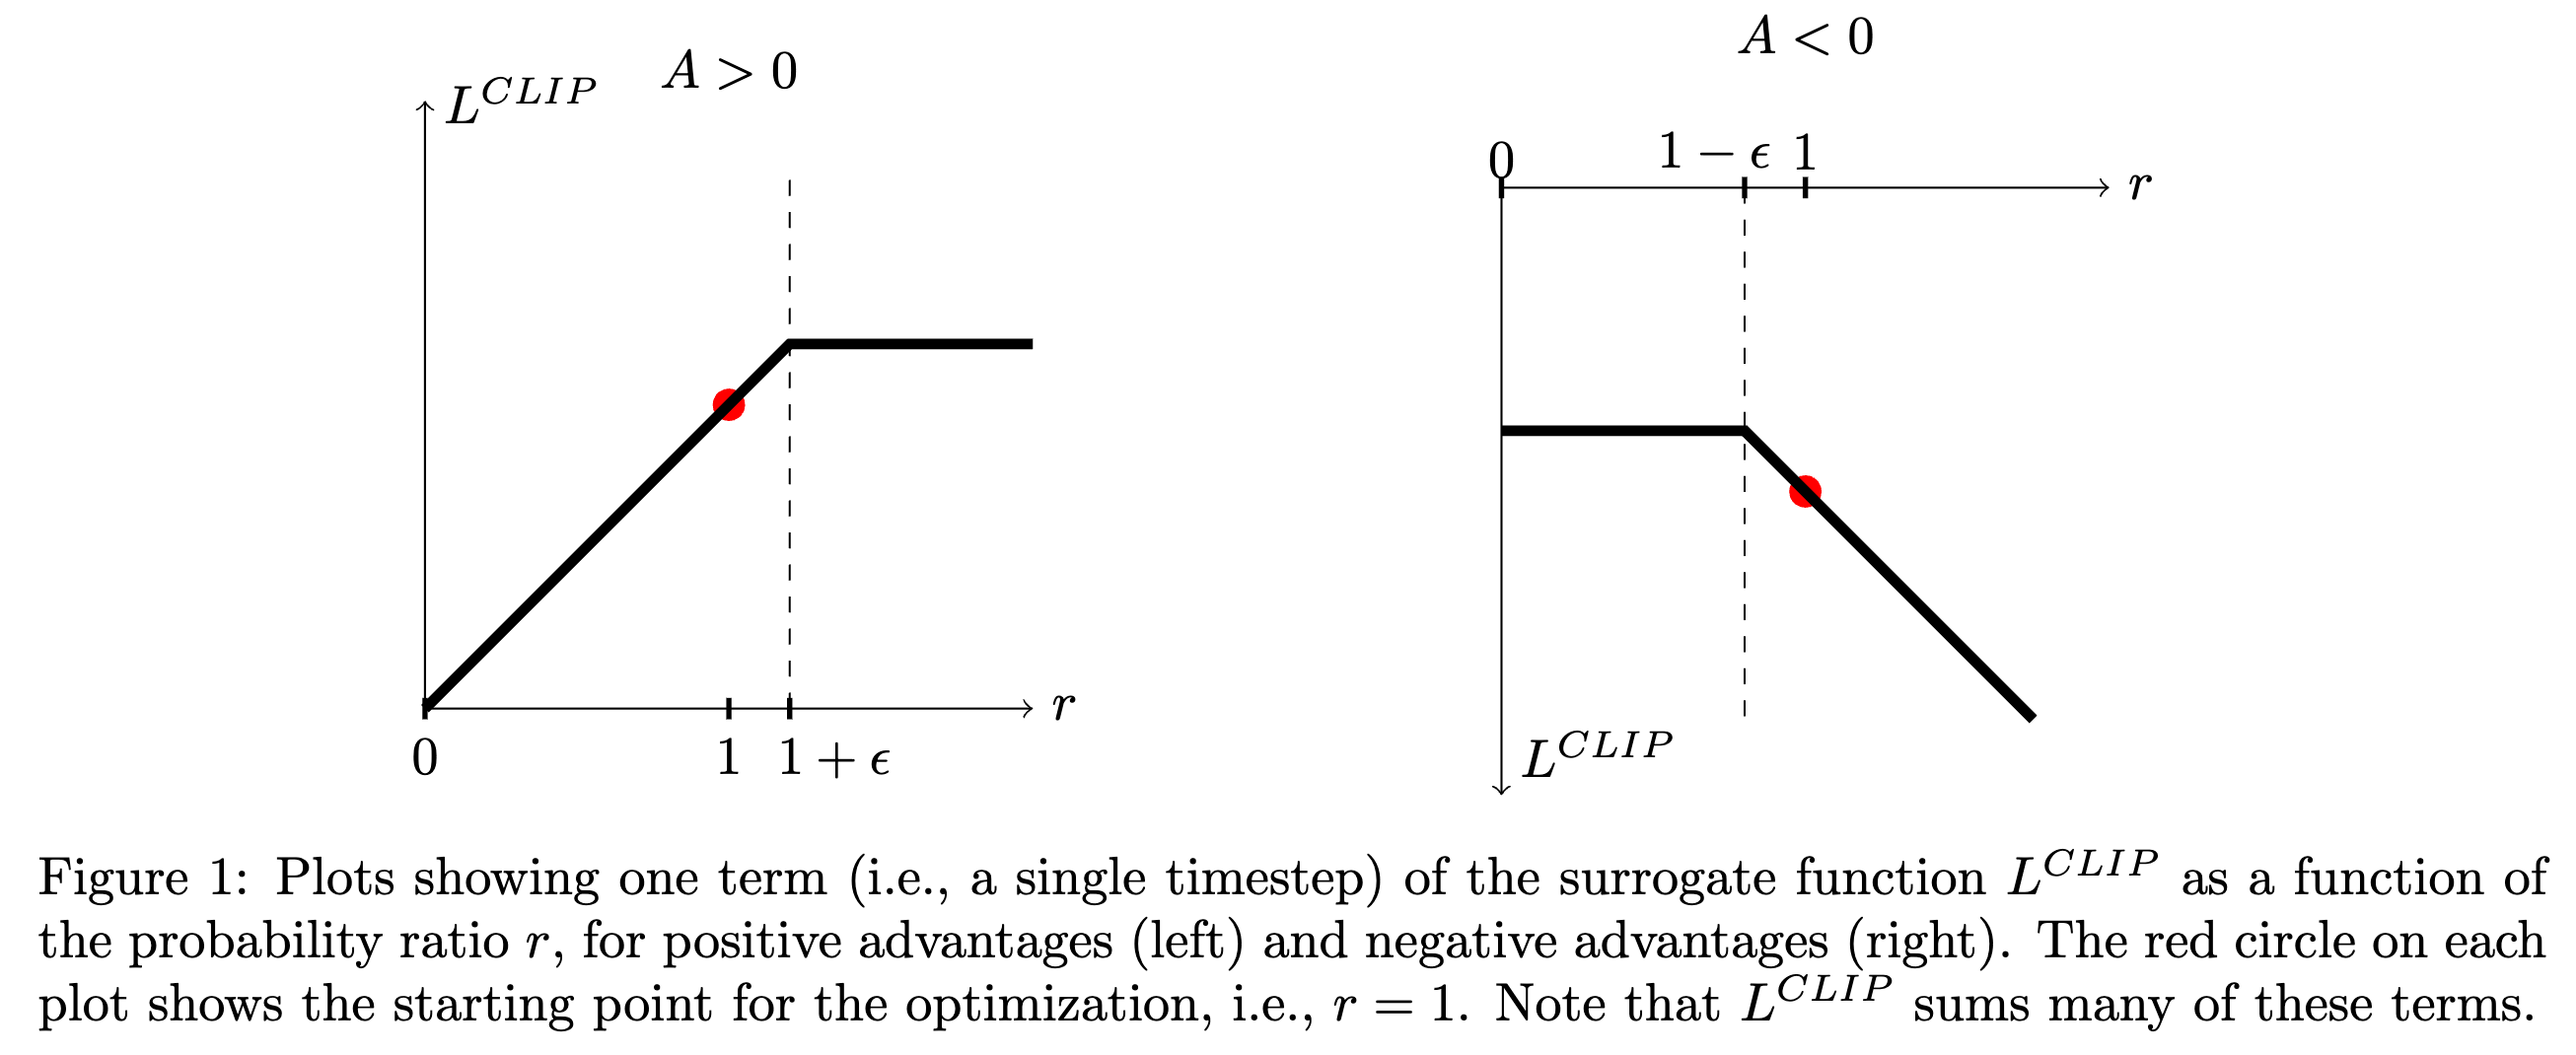

|$A_t$|$0\lt r_t\lt \infty$|$clip$|$min(r_tA_t, clip)$|
|--|------|----|------|
|+|$1+\epsilon \lt r_t\lt +\infty$|$1+\epsilon$|$(1+\epsilon)*A_t$|
|+|$1-\epsilon \lt r_t \lt 1+\epsilon$|$r_t$|$r_t*A_t$|
|+|$0\lt r_t \lt 1-\epsilon$|$1-\epsilon$|$r_t*A_t$|
|-|$1+\epsilon \lt r_t \lt +\infty$|$1+\epsilon$|$r_t*A_t$|
|-|$1-\epsilon \lt r_t \lt 1+\epsilon$|$r_t$|$r_t*A_t$|
|-|$0 \lt r_t \lt1-\epsilon$|$1-\epsilon$|$(1-\epsilon)*A_t$|

#### 策略更新对比
* 代理目标奖励函数
在 PPO（近端策略优化）论文的 Figure 2 中，** 线性插值因子（linear interpolation factor）** 是理解代理目标函数$L^{\text{CLIP}}$与原始目标$L^{\text{CPI}}$关系的关键。\
Figure 2 的实验基于连续控制问题，通过策略更新方向的线性插值（即从旧策略$\theta_{\text{old}}$到新策略$\theta_{\text{new}}$的插值），展示了多个目标函数的变化趋势。具体机制如下：
- 插值公式：
    - 设插值因子为$\epsilon \in [0, 1]$，中间策略为$\theta_{\epsilon} = \theta_{\text{old}} + \epsilon (\theta_{\text{new}} - \theta_{\text{old}})$。
    - 当$\epsilon = 0$时，策略为旧策略；
    - 当$\epsilon = 1$时，策略为新策略。
    - 中间值表示不同幅度的策略更新。

- 目标函数对比：
    - 实验对比了$L^{\text{CLIP}}$（裁剪后的代理目标）与$L^{\text{CPI}}$（保守策略迭代的原始目标），以及可能的其他目标（如 KL 散度、奖励函数等）。
![image.png](attachment:e6035d2f-addb-48b1-b9d4-0dcd9af1a4b5.png)

## 4. PPO 2: Adaptive KL Penalty Coefficient $\beta$
将KL散度约束作为惩罚项放到目标函数，同时自适应调节KL项惩罚系数$\beta$
$$L^{KLPEN}(\theta) = \hat{\mathbb{E}}[\cfrac{\pi_{\theta}(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t] - \beta KL[\pi_{old}(\cdot|s_t), \pi_{\theta}(\cdot|s_t))]$$

根据KL散度取值$d = \mathbb{\hat{E}}_t[KL[\pi_{old}(\cdot|s_t), \pi_{\theta}(\cdot|s_t))]]$自适应调节$\beta$:
- if $d < d_{tar}/1.5, \beta \leftarrow \beta/2$
- if $d > d_{tar} \times 1.5, \beta \leftarrow \beta\times2$




## 5. Algorithm
1. 很多算法为了降低优势函数的估计误差都会学习状态值函数$v(s)$，因此可以使用actor和critic共享的架构，例如:
    - [High-Dimensional Continuous Control Using Generalized Advantage Estimation
](https://arxiv.org/abs/1506.02438)
    - [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/abs/1602.01783)
2. 为了保证算法探索性能可以增加entropy bonus

$$L_t^{CLIP + VF + S}(\theta) = \mathbb{\hat{E}}_t[L_t^{CLIP}(\theta)- c_1L_t^{VF}(\theta) + c_2S[\pi_{\theta}](s_t)]$$
其中$L_t^{VF}(\theta) = (V_{\theta}(s_t) - V_t^{target})^2$

3. 有些PG算法runs the policy for $T$ timesteps，使用以下优势函数：
$$\hat{A}_t = r_t + \gamma r_{t+1} + ... + \gamma ^{T-t+1}r_{T-1} + \gamma ^{T-t}V(s_T) - V(s_t)$$
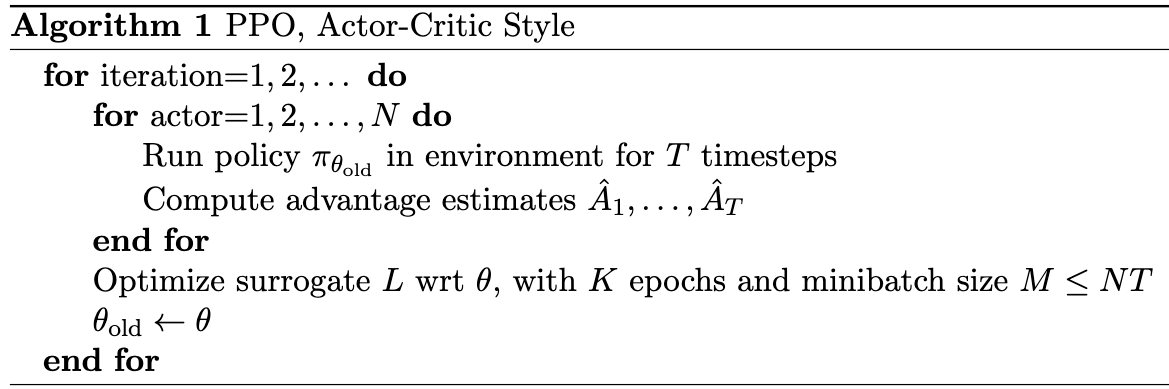